In [1]:
# Import necessary packages
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """
    Initialize the weights and biases for a neural network with a given architecture and scale.

    Parameters:
    scale (float): A scalar value that determines the scale of the random parameters.
    layer_sizes (list of integers): A list of integers representing the size of each layer in the neural network.
    rs (numpy.random.RandomState): An optional random state object (default: numpy.random.RandomState(0)).

    Returns:
    list of tuples: A list of tuples, where each tuple contains a weight matrix and a bias vector for a single layer in the neural network.
    """
    
    # Build a list of (weights, biases) tuples, one for each layer
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]
            # zip function  is used to pair up elements into tuples
            # layer_sizes[:-1] expression returns a new list that contains all the elements of layer_sizes except for the last one
            # layer_sizes[1:] expression returns a new list that contains all the elements of layer_sizes starting from the second one
            # Here we are using zip function to pair up the size of each layer in the neural network with the size of the next layer
            
            ## The zip function then pairs up the corresponding elements of these two lists into tuples. For example, if layer_sizes is [10, 5, 2], then layer_sizes[:-1] is [10, 5] and layer_sizes[1:] is [5, 2]. The zip function would then pair up the first element of layer_sizes[:-1] (which is 10) with the first element of layer_sizes[1:] (which is 5), and so on.
            
def activation(x):
    """
    Activation function used in the neural network.

    This function implements the Swish activation function, which is defined as x / (1.0 + np.exp(-x)).
    The Swish activation function was introduced in the paper "Searching for Activation Functions"
    by Ramachandran et al. (2017), which can be found at <https://arxiv.org/pdf/1710.05941.pdf>.

    Parameters:
    x (numpy array): The input data to the activation function, with arbitrary shape.

    Returns:
    numpy array: The output of the activation function, with the same shape as the input data.
    """
    
    # Swish activation function
    return x / (1.0 + np.exp(-x))

    # ReLU (Fukushima, K., 1975)
    # return np.maximum(0, x)

    # Leaky ReLU (LReLU) (Maas et al., 2013)
    # return np.maximum(0, 0.01*x)
    
    # Exponential Linear Unit (ELU) (Clevert et al., 2015)
    # return np.where(x > 0, x, np.exp(x) - 1)

    # Scaled Exponential Linear Unit (SELU) (Klambauer et al., 2017)
    # return np.where(x >= 0, 1.0507 * x, 1.0507 * 1.6733 * (np.exp(x) - 1))
    
    # Sigmoid (Minsky and Papert, 1969)
    # return 1 / (1 + np.exp(-x))
    
    # Tanh (Hinton et al., 1986)
    # return np.tanh(x)
    


def f_NN(params, inputs):
    """
    Compute the weighted sum of the inputs and the weights, and add the bias. Then, apply the activation function to the outputs

    Parameters:
    params (list of tuples): A list of tuples, where each tuple contains a weight matrix and a bias vector for a single layer in the neural network.
    inputs (numpy array): The input data to the neural network, with shape (num_samples, num_features).

    Returns:
    numpy array: The output of the neural network, with shape (num_samples, num_outputs).
    """
    
    # Iterate over the layers in the neural network
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = activation(outputs)
    return outputs



In [2]:
# Initialize the parameters of the neural network
NN_architecture = [1, 8, 8, 8, 1]
params = init_random_params(0.1, layer_sizes=NN_architecture)

# Compute the gradient of the objective function with respect to the parameters
f_NN_p = elementwise_grad(f_NN, 1)
f_NN_pp = elementwise_grad(f_NN_p, 1)

# Define the input data for the neural network
left = 0
right = np.pi/2
num_points = 100

def normalization(x, left, right):
    """
    Normalize a value within a given range.

    Parameters:
    x (float): The value to be normalized.
    left (float): The left boundary of the range.
    right (float): The right boundary of the range.

    Returns:
    float: The normalized value.

    """
    return (2*x-(right+left))/(right-left)

def denormalization(x, left, right):
    """
    Denormalizes a value `x` from a normalized range to the original range.

    Parameters:
    - x (float): The value to be denormalized.
    - left (float): The left boundary of the original range.
    - right (float): The right boundary of the original range.

    Returns:
    float: The denormalized value.
    
    """
    return ((right - left) * x + right + left) / 2

x_span = np.linspace(left, right, num_points).reshape((-1, 1))
eta = normalization(x_span,left,right)
x_ic = 0.0

def objective(params, step):
    """
    Objective function for the neural network.

    This function computes the objective function for the neural network, which is defined as the mean squared error
    of the constraint equation and the initial condition.

    Parameters:
    params (list of tuples): A list of tuples, where each tuple contains a weight matrix and a bias vector for a single layer in the neural network.
    step (integer): The current iteration number.

    Returns:
    float: The value of the objective function.
    """
    
    # These should all be zero at the solution
    # y'² + y² - 1 = 0
    # y(0) = 0
    zeq = f_NN_p(params, eta)**2 + f_NN(params, eta)**2 -1
    ic0 = f_NN(params, normalization(x_ic, left, right))
    return np.mean(zeq**2) + ic0**2 

def callback(params, step, g):
    """
    Callback function for the optimization algorithm.

    This function is called at each iteration of the optimization algorithm, and prints the current iteration number
    and the value of the objective function.

    Parameters:
    params (list of tuples): A list of tuples, where each tuple contains a weight matrix and a bias vector for a single layer in the neural network.
    step (integer): The current iteration number.
    g (numpy array): The gradient of the objective function with respect to the parameters.

    Returns:
    None
    """
    
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))
    
    # Check if the objective value is less than 1e-6
    if objective(params, step) < 1e-6:
        raise StopIteration
    


In [3]:
try:
    params = adam(grad(objective), params,
              step_size=0.001, num_iters=15000, callback=callback)
except StopIteration:
    print("Optimization stopped because the objective value is less than 1e-6.")
"""
Adam is basically RMSprop with momentum and some correction terms.
Parameters:
grad (function): A function that computes the gradient of the objective function with respect to the parameters.
step_size (float): The step size for the optimization algorithm (default: 0.001).
num_iters (integer): The number of iterations (default: 100).
callback (function): A function that is called at each iteration of the optimization algorithm (default: None).
Returns:
list of tuples: The optimized parameters of the neural network.
"""


Iteration   0 objective [[0.98844256]]
Iteration 1000 objective [[0.00028313]]
Iteration 2000 objective [[0.00014361]]
Iteration 3000 objective [[9.39370108e-05]]
Iteration 4000 objective [[6.35080948e-05]]
Iteration 5000 objective [[4.81171477e-05]]
Iteration 6000 objective [[4.17359452e-05]]
Iteration 7000 objective [[3.93134342e-05]]
Iteration 8000 objective [[3.75108172e-05]]
Iteration 9000 objective [[3.51468351e-05]]
Iteration 10000 objective [[3.24971127e-05]]
Iteration 11000 objective [[2.92609624e-05]]
Iteration 12000 objective [[2.4973141e-05]]
Iteration 13000 objective [[1.88708016e-05]]
Iteration 14000 objective [[9.29317312e-06]]


'\nAdam is basically RMSprop with momentum and some correction terms.\nParameters:\ngrad (function): A function that computes the gradient of the objective function with respect to the parameters.\nstep_size (float): The step size for the optimization algorithm (default: 0.001).\nnum_iters (integer): The number of iterations (default: 100).\ncallback (function): A function that is called at each iteration of the optimization algorithm (default: None).\nReturns:\nlist of tuples: The optimized parameters of the neural network.\n'

In [4]:
# Defining analytic solution for comparing plots
def f_analytic(x):
    f = np.sin(x)
    return f

# Verifying if it has met the IC
print(f'f_NN({x_ic:.4}) = {np.float64(f_NN(params, normalization(x_ic, left, right))):.4e}')
print(f"f_analytic({x_ic:.4}) = {f_analytic(x_ic):.4e}")
print(f'Error = {abs(np.float64(f_NN(params, normalization(x_ic, left, right))) - f_analytic(x_ic)):.4e}')



f_NN(0.0) = -8.0710e-06
f_analytic(0.0) = 0.0000e+00
Error = 8.0710e-06


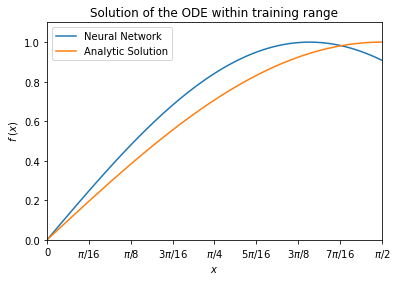

In [5]:
# Visualization of results
plt.plot(x_span, f_NN(params, eta), label='f_NN')
plt.plot(x_span, f_analytic(x_span), label='f_analytic')
plt.title('Solution of the ODE within training range')
plt.xlabel('$x$')
plt.ylabel('$f\;(x)$')
plt.legend(['Neural Network', 'Analytic Solution'])
plt.xlim([left,right])
plt.ylim(min(np.min(f_NN(params, eta)), np.min(f_analytic(x_span)))*1.1, max(np.max(f_NN(params, eta)), np.max(f_analytic(x_span)))*1.1)
plt.xticks([0, np.pi/16, 2*np.pi/16, 3*np.pi/16, 4*np.pi/16, 5*np.pi/16, 6*np.pi/16, 7*np.pi/16, 8*np.pi/16], ['0', '$\pi/16$', '$\pi/8$', '$3\pi/16$', '$\pi/4$', '$5\pi/16$', '$3\pi/8$', '$7\pi/16$', '$\pi/2$'])  
plt.show()

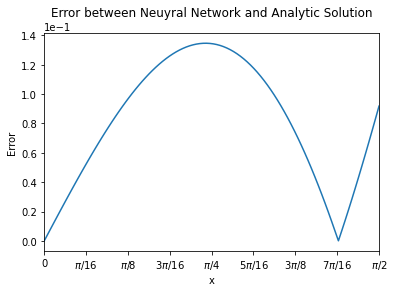

In [6]:
plt.plot(x_span, np.abs(f_NN(params, eta) - f_analytic(x_span)))
plt.xlabel('x')
plt.ylabel('Error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlim([left,right])
plt.xticks([0, np.pi/16, 2*np.pi/16, 3*np.pi/16, 4*np.pi/16, 5*np.pi/16, 6*np.pi/16, 7*np.pi/16, 8*np.pi/16], ['0', '$\pi/16$', '$\pi/8$', '$3\pi/16$', '$\pi/4$', '$5\pi/16$', '$3\pi/8$', '$7\pi/16$', '$\pi/2$']) 
plt.title('Error between Neuyral Network and Analytic Solution')
plt.show()

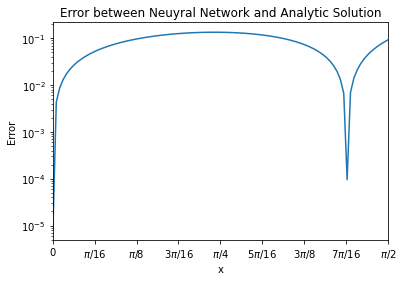

In [7]:
plt.semilogy(x_span, np.abs(f_NN(params, eta) - f_analytic(x_span)))
plt.xlabel('x')
plt.ylabel('Error')
plt.xlim([left,right])
plt.xticks([0, np.pi/16, 2*np.pi/16, 3*np.pi/16, 4*np.pi/16, 5*np.pi/16, 6*np.pi/16, 7*np.pi/16, 8*np.pi/16], ['0', '$\pi/16$', '$\pi/8$', '$3\pi/16$', '$\pi/4$', '$5\pi/16$', '$3\pi/8$', '$7\pi/16$', '$\pi/2$'])  
plt.title('Error between Neuyral Network and Analytic Solution')
plt.show()

In [8]:
# Verifying in the other extremity
print(f'f_NN({right:.4}) = {np.float64(f_NN(params, normalization(right,left,right))):.4e}')
print(f"f_analytic({right:.4}) = {f_analytic(right):.4e}")
print(f'Error = {abs(np.float64(f_NN(params, normalization(right,left,right))) - f_analytic(right)):.4e}')

f_NN(1.571) = 9.0816e-01
f_analytic(1.571) = 1.0000e+00
Error = 9.1840e-02


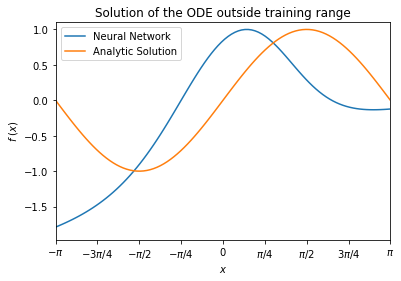

In [9]:
x_span2 = np.linspace(-np.pi, np.pi,num_points).reshape((-1, 1))
eta2 = 4*eta
plt.plot(x_span2, f_NN(params, eta2), label='f_NN')
plt.plot(x_span2, f_analytic(x_span2), label='f_analytic')
plt.title('Solution of the ODE outside training range')
plt.xlabel('$x$')
plt.ylabel('$f\;(x)$')
plt.legend(['Neural Network', 'Analytic Solution'])
plt.xlim([-np.pi,np.pi]) 
plt.ylim(min(np.min(f_NN(params, eta2)), np.min(f_analytic(x_span2)))*1.1, max(np.max(f_NN(params, eta2)), np.max(f_analytic(x_span2)))*1.1)
plt.xticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
           ['$-\pi$', '$-3\pi/4$', '$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])  

plt.show()

In [10]:
params_shape = [(insize, outsize, outsize) for insize, outsize in zip(NN_architecture[:-1], NN_architecture[1:])]

In [11]:
params_shape

[(1, 8, 8), (8, 8, 8), (8, 8, 8), (8, 1, 1)]